In [1]:
# =============================================================================
# INSTALLATION & IMPORTS
# =============================================================================
!pip install pyspark findspark -q

import findspark
findspark.init()

import builtins
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from google.colab import files


spark = SparkSession.builder \
    .appName("CSCI323_WineQuality_Advanced_Modeling") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

print(f"Spark version: {spark.version}")
print("Setup completed successfully!")


Spark version: 3.5.1
Setup completed successfully!


In [2]:
# =============================================================================
# DATA LOADING
# =============================================================================
from io import StringIO
import csv
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
print("\n" + "="*60)
print("STEP 1: DATA LOADING")
print("="*60)

print("Please upload BOTH winequality-red.csv and winequality-white.csv (hold Ctrl/Cmd):")
uploaded = files.upload()

df_red = None
df_white = None

for filename in uploaded.keys():
    print(f"Loading {filename}...")
    data = uploaded[filename].decode('utf-8')
    lines = list(csv.reader(StringIO(data), delimiter=';'))
    header = lines[0]
    rows = lines[1:]
    schema = StructType([StructField(h.replace(' ', '_'), DoubleType(), True) for h in header])
    rdd = spark.sparkContext.parallelize(rows).map(lambda x: [float(v) for v in x])
    temp_df = spark.createDataFrame(rdd, schema)

    if 'red' in filename.lower():
        df_red = temp_df.withColumn("wine_type", lit("red"))
    elif 'white' in filename.lower():
        df_white = temp_df.withColumn("wine_type", lit("white"))

if df_red is None or df_white is None:
    raise ValueError("Both red and white CSV files must be uploaded!")

print(f"Red records: {df_red.count():,}, White records: {df_white.count():,}")


STEP 1: DATA LOADING
Please upload BOTH winequality-red.csv and winequality-white.csv (hold Ctrl/Cmd):


Saving winequality-red.csv to winequality-red.csv
Saving winequality-white.csv to winequality-white.csv
Loading winequality-red.csv...
Loading winequality-white.csv...
Red records: 1,599, White records: 4,898



STEP 1: DISCOVER AND VISUALIZE THE DATA (Wine Quality) – RED & WHITE SEPARATELY

--- Red Wine ---
Shape: (1599, 13)

--- White Wine ---
Shape: (4898, 13)

Schema – Red Wine:
root
 |-- fixed_acidity: double (nullable = true)
 |-- volatile_acidity: double (nullable = true)
 |-- citric_acid: double (nullable = true)
 |-- residual_sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free_sulfur_dioxide: double (nullable = true)
 |-- total_sulfur_dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: double (nullable = true)
 |-- wine_type: string (nullable = false)


First 5 rows – Red Wine:
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+---------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000
mean,8.320,0.528,0.271,2.539,0.087,15.875,46.468,0.997,3.311,0.658,10.423,5.636
std,1.741,0.179,0.195,1.410,0.047,10.460,32.895,0.002,0.154,0.170,1.066,0.808
min,4.600,0.120,0.000,0.900,0.012,1.000,6.000,0.990,2.740,0.330,8.400,3.000
25%,7.100,0.390,0.090,1.900,0.070,7.000,22.000,0.996,3.210,0.550,9.500,5.000
50%,7.900,0.520,0.260,2.200,0.079,14.000,38.000,0.997,3.310,0.620,10.200,6.000
75%,9.200,0.640,0.420,2.600,0.090,21.000,62.000,0.998,3.400,0.730,11.100,6.000
max,15.900,1.580,1.000,15.500,0.611,72.000,289.000,1.004,4.010,2.000,14.900,8.000



Basic Statistics – White Wine:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000,4898.000
mean,6.855,0.278,0.334,6.391,0.046,35.308,138.361,0.994,3.188,0.490,10.514,5.878
std,0.844,0.101,0.121,5.072,0.022,17.007,42.498,0.003,0.151,0.114,1.231,0.886
min,3.800,0.080,0.000,0.600,0.009,2.000,9.000,0.987,2.720,0.220,8.000,3.000
25%,6.300,0.210,0.270,1.700,0.036,23.000,108.000,0.992,3.090,0.410,9.500,5.000
50%,6.800,0.260,0.320,5.200,0.043,34.000,134.000,0.994,3.180,0.470,10.400,6.000
75%,7.300,0.320,0.390,9.900,0.050,46.000,167.000,0.996,3.280,0.550,11.400,6.000
max,14.200,1.100,1.660,65.800,0.346,289.000,440.000,1.039,3.820,1.080,14.200,9.000


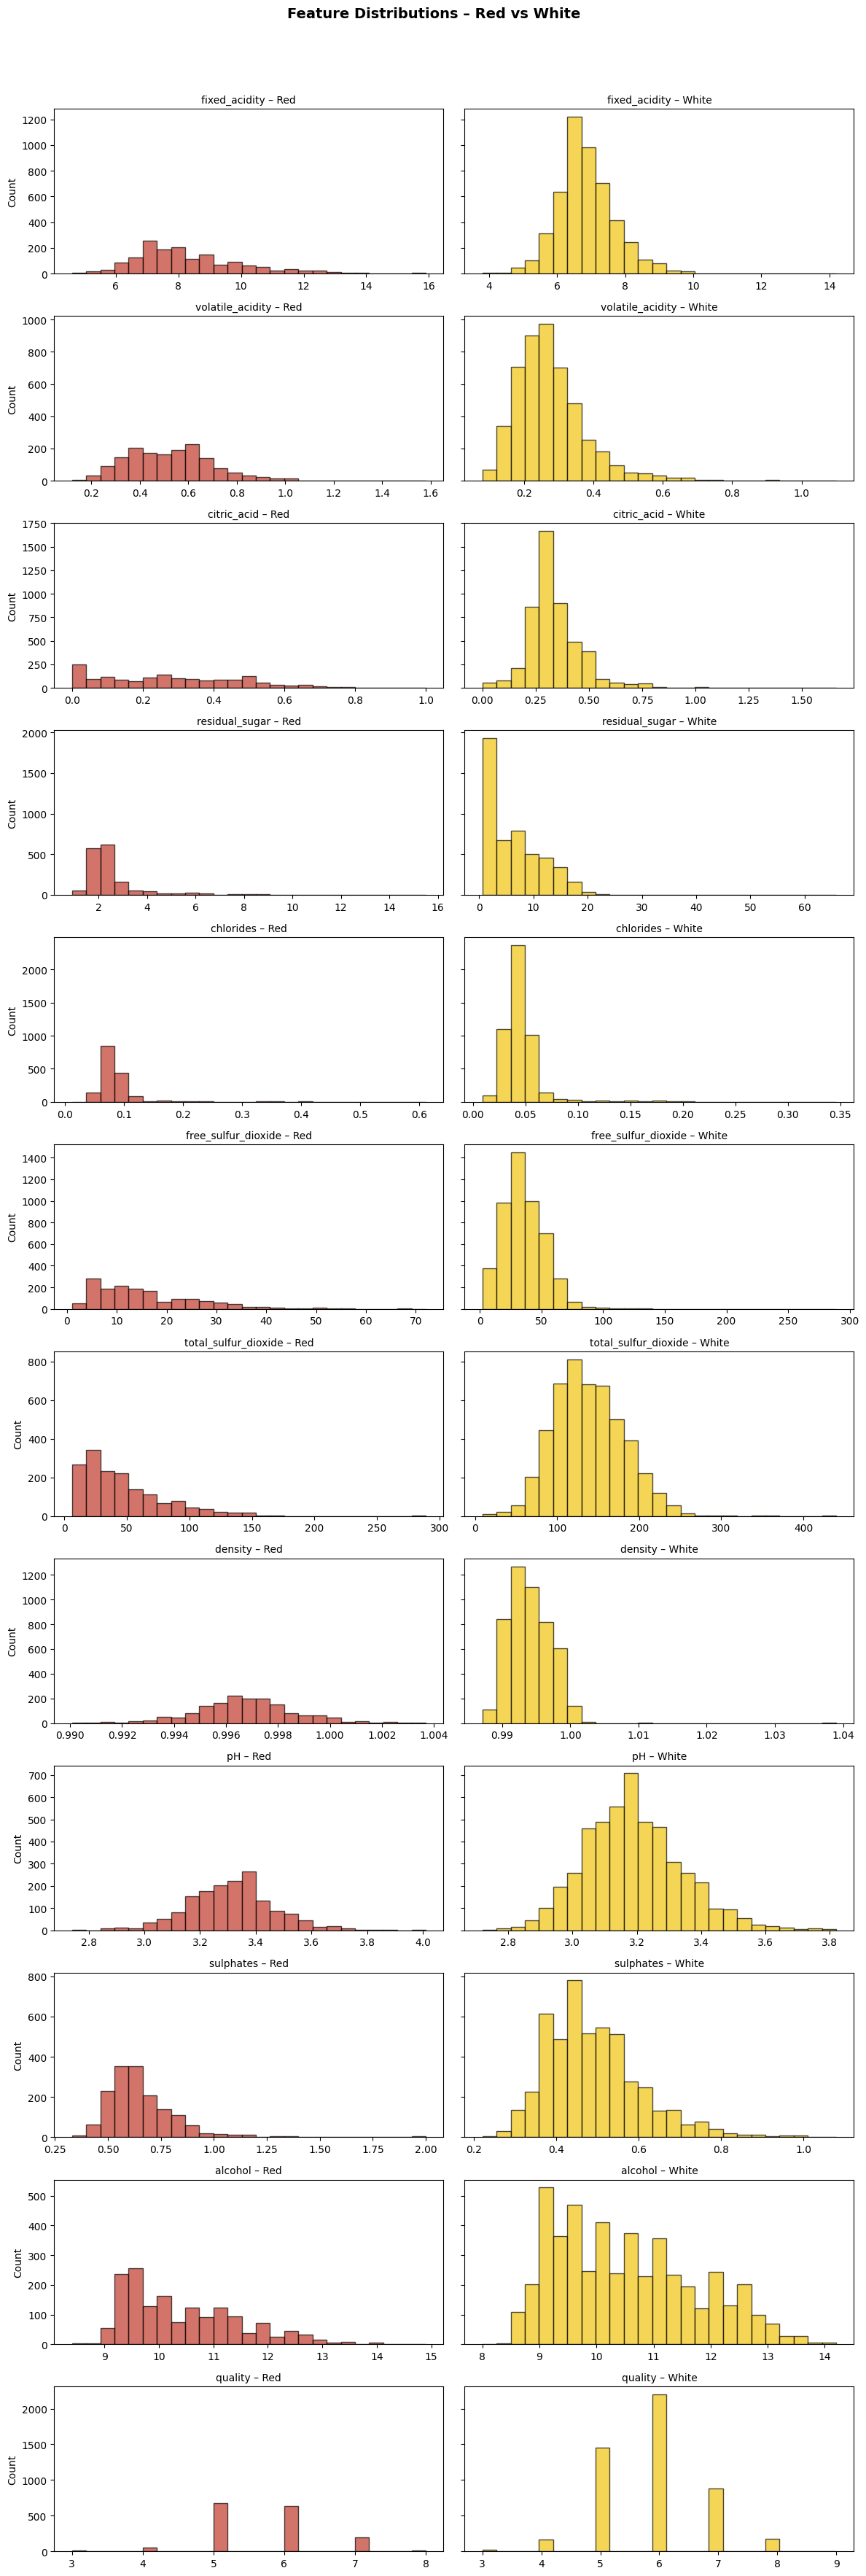

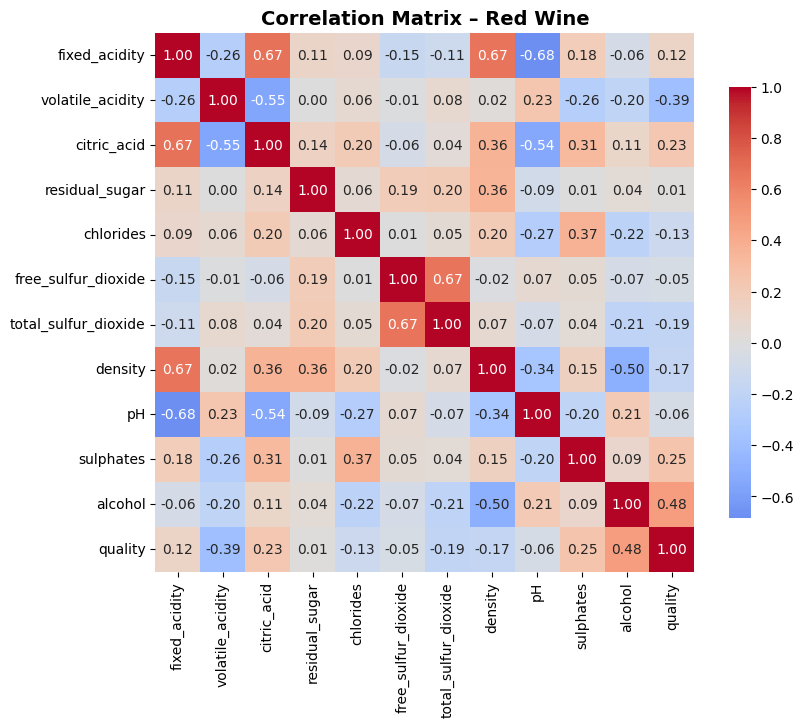

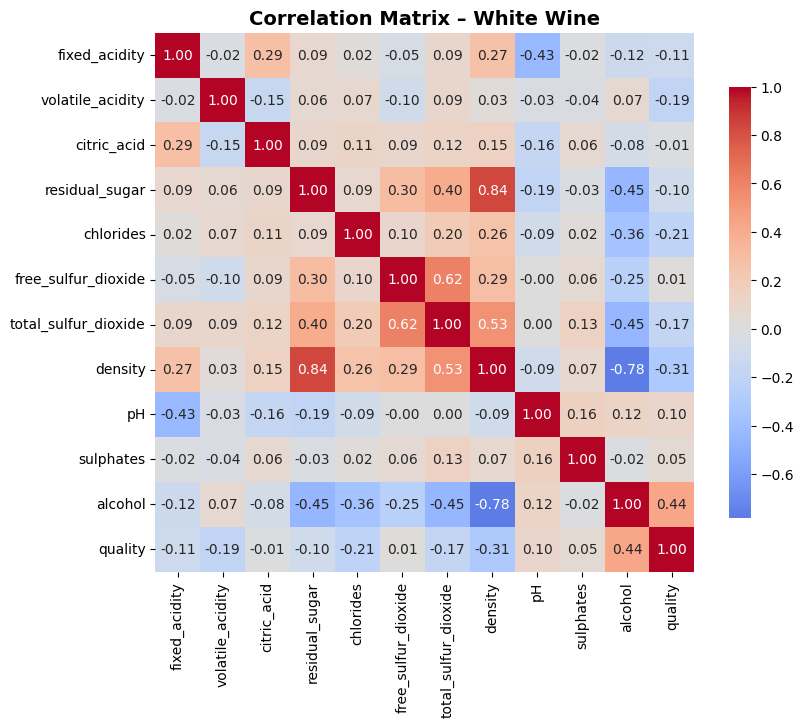

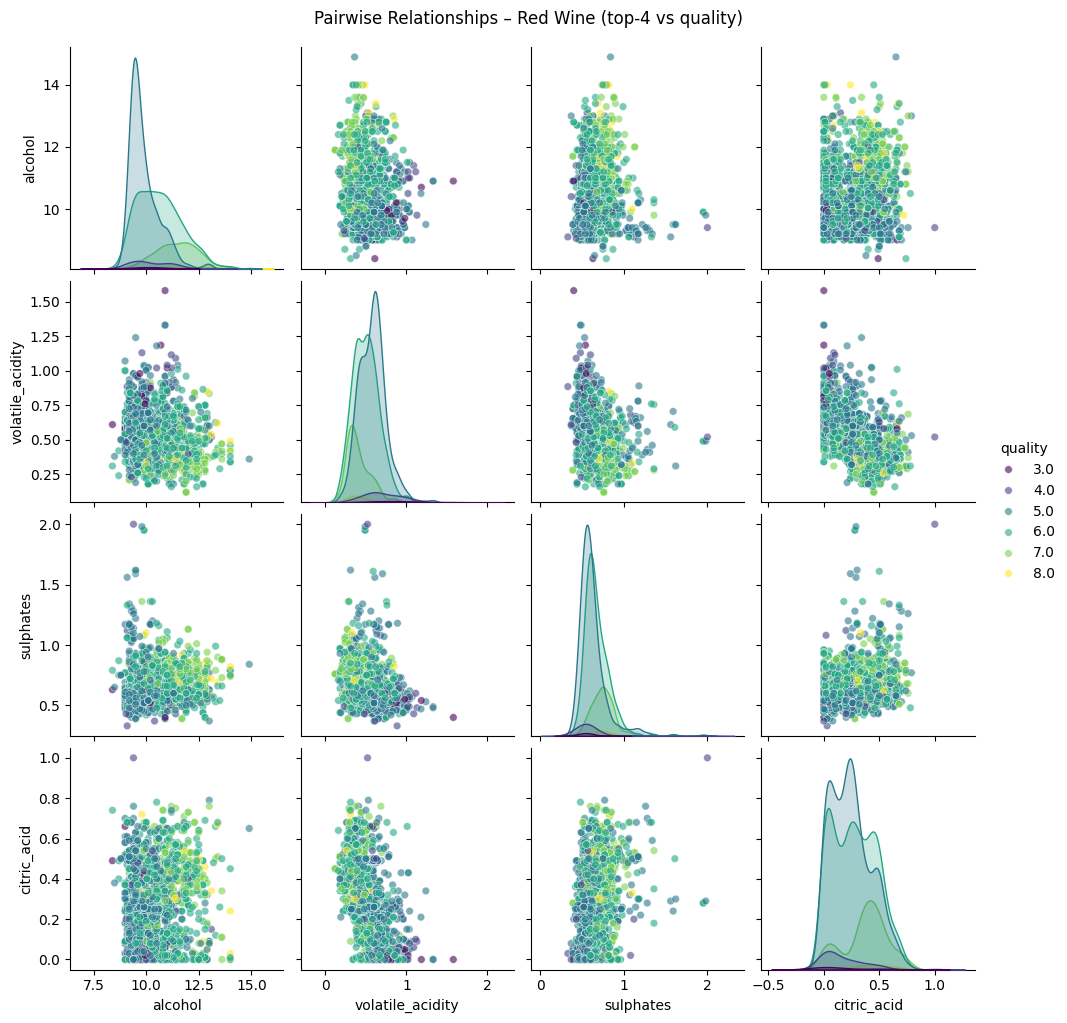

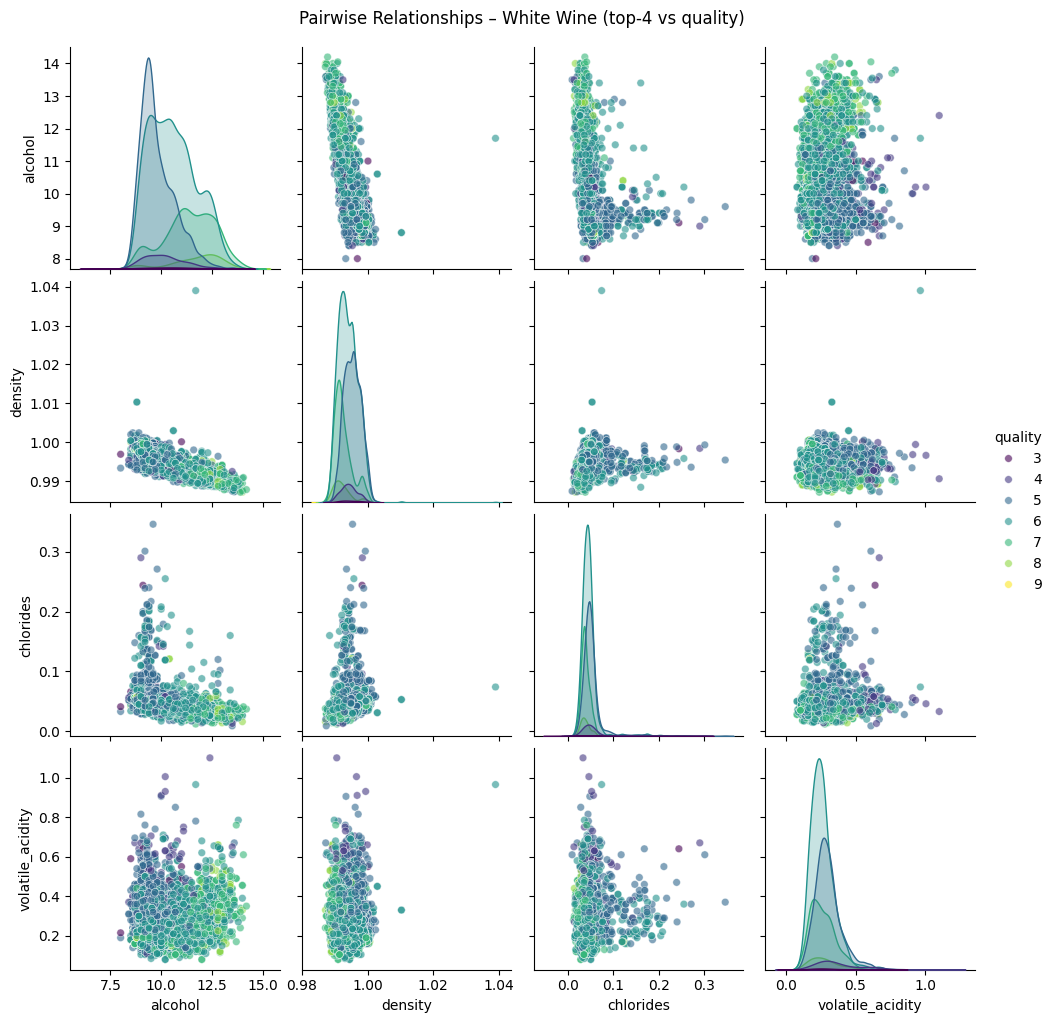

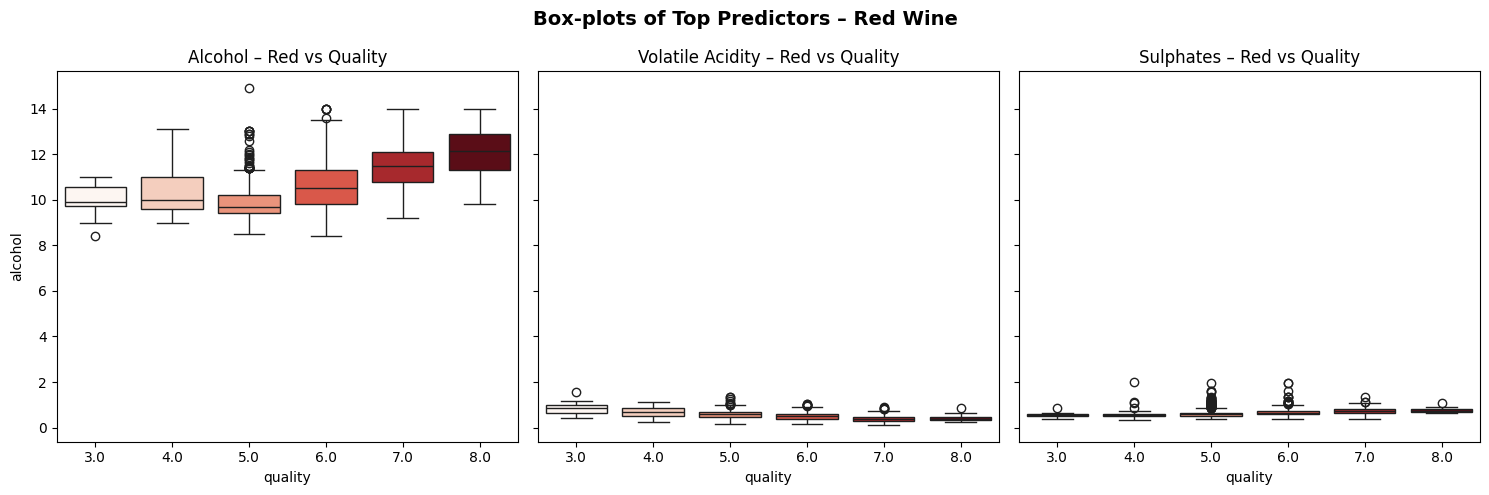

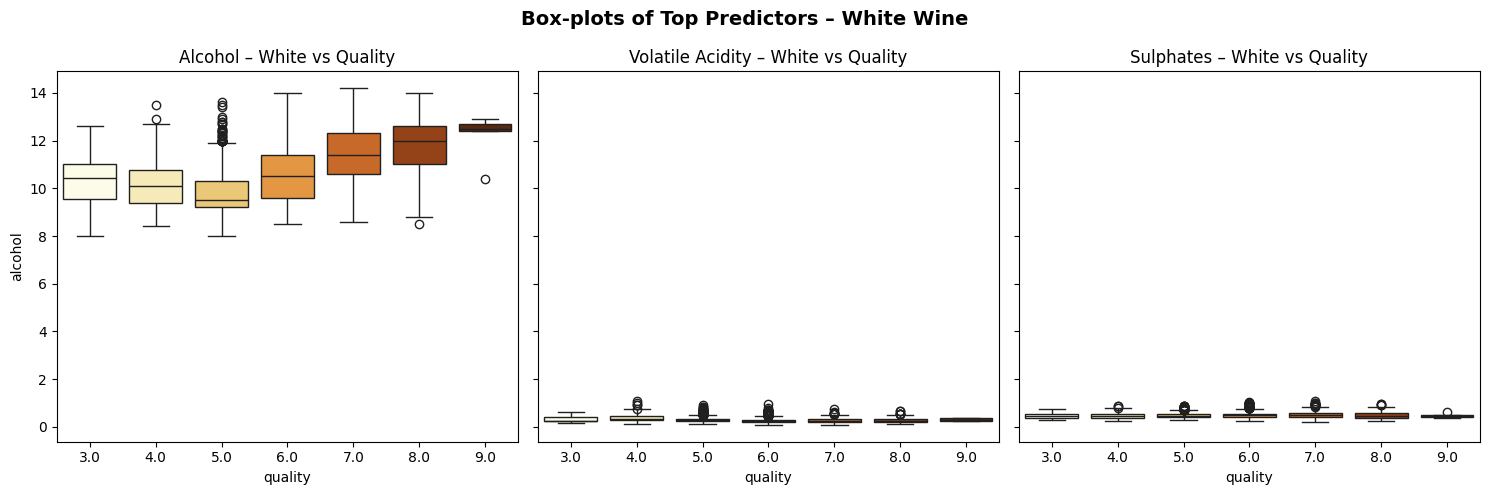


Data exploration completed successfully!


In [3]:
# =============================================================================
# STEP 1: DISCOVER AND VISUALIZE THE DATA (Wine Quality)
# =============================================================================

print("\n" + "="*50)
print("STEP 1: DISCOVER AND VISUALIZE THE DATA (Wine Quality)")
print("="*50)

from pyspark.sql.functions import col, count, when
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# -----------------------------------------------------------------
#  convert a Spark DF → Pandas
# -----------------------------------------------------------------
def spark_to_pd(df_spark, name):
    print(f"\n--- {name} Wine ---")
    df_pd = df_spark.toPandas()
    print(f"Shape: {df_pd.shape}")
    return df_pd

# -----------------------------------------------------------------
# 1. Load the two Pandas frames
# -----------------------------------------------------------------
df_red_pd  = spark_to_pd(df_red,  "Red")
df_white_pd = spark_to_pd(df_white, "White")

# -----------------------------------------------------------------
# 2. SCHEMA & SAMPLE ROWS (per wine)
# -----------------------------------------------------------------
def show_schema_and_sample(df_spark, name):
    print(f"\nSchema – {name} Wine:")
    df_spark.printSchema()
    print(f"\nFirst 5 rows – {name} Wine:")
    df_spark.show(5, truncate=False)

show_schema_and_sample(df_red,  "Red")
show_schema_and_sample(df_white, "White")

# -----------------------------------------------------------------
# 3. MISSING VALUES (per wine)
# -----------------------------------------------------------------
def missing_report(df_spark, name):
    print(f"\nMissing Values – {name} Wine:")
    missing = df_spark.select([count(when(col(c).isNull(), c)).alias(c) for c in df_spark.columns])
    missing.show()

missing_report(df_red,  "Red")
missing_report(df_white, "White")

# -----------------------------------------------------------------
# 4. BASIC STATISTICS (per wine)
# -----------------------------------------------------------------
def basic_stats(df_pd, name):
    print(f"\nBasic Statistics – {name} Wine:")
    display(df_pd.describe().round(3))

basic_stats(df_red_pd,  "Red")
basic_stats(df_white_pd, "White")

# -----------------------------------------------------------------
# 5. HISTOGRAMS
# -----------------------------------------------------------------
num_features = [c for c in df_red_pd.columns if c != "wine_type"]

fig, axes = plt.subplots(len(num_features), 2,
                         figsize=(12, 3*len(num_features)),
                         sharey='row')

for i, feat in enumerate(num_features):
    # Red
    axes[i,0].hist(df_red_pd[feat], bins=25, color='#C0392B', alpha=0.7, edgecolor='k')
    axes[i,0].set_title(f"{feat} – Red", fontsize=10)
    axes[i,0].set_ylabel("Count")

    # White
    axes[i,1].hist(df_white_pd[feat], bins=25, color='#F1C40F', alpha=0.7, edgecolor='k')
    axes[i,1].set_title(f"{feat} – White", fontsize=10)

plt.suptitle("Feature Distributions – Red vs White", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# -----------------------------------------------------------------
# 6. CORRELATION HEATMAP (per wine)
# -----------------------------------------------------------------
def corr_heatmap(df_pd, name, cmap='coolwarm'):
    # Exclude non-numeric columns like 'wine_type' before calculating correlation
    numeric_df_pd = df_pd.select_dtypes(include=np.number)
    corr = numeric_df_pd.corr()
    plt.figure(figsize=(9,7))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, center=0,
                square=True, cbar_kws={"shrink": .8})
    plt.title(f"Correlation Matrix – {name} Wine", fontsize=14, fontweight='bold')
    plt.show()
    return corr

corr_red   = corr_heatmap(df_red_pd,   "Red")
corr_white = corr_heatmap(df_white_pd, "White")

# -----------------------------------------------------------------
# 7. PAIR-PLOT of top-4 features correlated with quality (per wine)
# -----------------------------------------------------------------
def top_pairplot(df_pd, name):
    # Calculate correlation within the function scope, excluding non-numeric columns
    numeric_df_pd = df_pd.select_dtypes(include=np.number)
    corr_matrix_pd = numeric_df_pd.corr()
    # Sort values of the 'quality' column
    top4 = corr_matrix_pd['quality'].abs().sort_values(ascending=False).index[1:5]

    sns.pairplot(df_pd, vars=top4, hue='quality',
                 palette='viridis', diag_kind='kde',
                 plot_kws=dict(alpha=0.6, s=30))
    plt.suptitle(f"Pairwise Relationships – {name} Wine (top-4 vs quality)", y=1.02)
    plt.show()

top_pairplot(df_red_pd,   "Red")
top_pairplot(df_white_pd, "White")

# -----------------------------------------------------------------
# 8. BOX-PLOTS: top-3 predictors vs quality (per wine)
# -----------------------------------------------------------------
# Corrected column names to use underscores
top_predictors = ['alcohol', 'volatile_acidity', 'sulphates']

fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)

for i, colname in enumerate(top_predictors):
    # Red
    sns.boxplot(ax=axes[i], x='quality', y=colname, data=df_red_pd,
                palette='Reds', hue='quality', legend=False)
    axes[i].set_title(f"{colname.replace('_', ' ').title()} – Red vs Quality") # Display titles nicely

plt.suptitle("Box-plots of Top Predictors – Red Wine", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)
for i, colname in enumerate(top_predictors):
    # White
    sns.boxplot(ax=axes[i], x='quality', y=colname, data=df_white_pd,
                palette='YlOrBr', hue='quality', legend=False)
    axes[i].set_title(f"{colname.replace('_', ' ').title()} – White vs Quality") # Display titles nicely

plt.suptitle("Box-plots of Top Predictors – White Wine", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nData exploration completed successfully!")

In [4]:
# =============================================================================
# STEP 2: FEATURE ENGINEERING & SCALING + STRATIFIED SPLIT + OVERSAMPLING
# =============================================================================
def prepare_data(df):
    feature_cols = [c for c in df.columns if c not in ["quality", "wine_type"]]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_assembled = assembler.transform(df)

    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
    scaler_model = scaler.fit(df_assembled)
    df_scaled = scaler_model.transform(df_assembled)

    df_final = df_scaled.select("scaledFeatures", "quality").withColumnRenamed("quality", "label")
    df_final.cache()
    return df_final

df_red_final = prepare_data(df_red)
df_white_final = prepare_data(df_white)

# -----------------------------------------------------------------
# STRATIFIED SPLIT + SMOTE-STYLE OVERSAMPLING
# -----------------------------------------------------------------
from pyspark.sql.functions import rand, col

def stratified_split_and_oversample(df, label_col="label", test_ratio=0.2, seed=42):
    df = df.withColumn("split_rand", rand(seed))
    counts = df.groupBy(label_col).count().collect()
    count_dict = {row[label_col]: row["count"] for row in counts}
    max_count = builtins.max(count_dict.values())

    train_parts = []
    test_parts = []

    for quality, cnt in count_dict.items():
        subset = df.filter(col(label_col) == quality)
        test_subset = subset.filter(col("split_rand") < test_ratio)
        train_subset = subset.filter(col("split_rand") >= test_ratio)

        if cnt < max_count:
            ratio = max_count / cnt
            train_oversampled = train_subset.sample(withReplacement=True, fraction=ratio, seed=seed)
        else:
            train_oversampled = train_subset

        train_parts.append(train_oversampled)
        test_parts.append(test_subset)

    train_balanced = train_parts[0]
    for part in train_parts[1:]:
        train_balanced = train_balanced.union(part)

    test_original = test_parts[0]
    for part in test_parts[1:]:
        test_original = test_original.union(part)

    return train_balanced, test_original

# Apply
train_red, test_red = stratified_split_and_oversample(df_red_final, "label", test_ratio=0.2, seed=42)
train_white, test_white = stratified_split_and_oversample(df_white_final, "label", test_ratio=0.2, seed=42)

print(f"Red:   Train={train_red.count():,}, Test={test_red.count():,}")
print(f"White: Train={train_white.count():,}, Test={test_white.count():,}")

print("\nRed Train Distribution (After Oversampling):")
train_red.groupBy("label").count().orderBy("label").show()

print("White Train Distribution (After Oversampling):")
train_white.groupBy("label").count().orderBy("label").show()

Red:   Train=3,190, Test=314
White: Train=11,734, Test=974

Red Train Distribution (After Oversampling):
+-----+-----+
|label|count|
+-----+-----+
|  3.0|  598|
|  4.0|  484|
|  5.0|  535|
|  6.0|  542|
|  7.0|  594|
|  8.0|  437|
+-----+-----+

White Train Distribution (After Oversampling):
+-----+-----+
|label|count|
+-----+-----+
|  3.0| 1681|
|  4.0| 1734|
|  5.0| 1721|
|  6.0| 1776|
|  7.0| 1794|
|  8.0| 1671|
|  9.0| 1357|
+-----+-----+



In [5]:
# =============================================================================
# STEP 4: TRAIN & EVALUATE MODELS
# =============================================================================
def train_and_evaluate(train_df, test_df, wine_type):
    print(f"\n{'='*20} Training Models for {wine_type} Wine {'='*20}")

    evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    evaluator_r2   = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

    results = {"wine_type": wine_type}

    # ---- GBT ----
    gbt = GBTRegressor(featuresCol="scaledFeatures", labelCol="label", maxIter=100, seed=42)
    gbt_model = gbt.fit(train_df)
    gbt_pred  = gbt_model.transform(test_df)
    gbt_rmse  = evaluator_rmse.evaluate(gbt_pred)
    gbt_r2    = evaluator_r2.evaluate(gbt_pred)
    print(f"\nGBT Regressor ({wine_type}) to RMSE: {gbt_rmse:.4f}, R²: {gbt_r2:.4f}")
    results.update({"gbt_rmse": gbt_rmse, "gbt_r2": gbt_r2})

    # ----  (Lasso) ----
    ls_l1 = LinearRegression(
        featuresCol="scaledFeatures", labelCol="label",
        elasticNetParam=1.0, regParam=0.01, maxIter=100
    )
    ls_l1_model = ls_l1.fit(train_df)
    ls_l1_pred  = ls_l1_model.transform(test_df)
    ls_l1_rmse  = evaluator_rmse.evaluate(ls_l1_pred)
    ls_l1_r2    = evaluator_r2.evaluate(ls_l1_pred)
    print(f"ls (Lasso) ({wine_type}) to RMSE: {ls_l1_rmse:.4f}, R²: {ls_l1_r2:.4f}")
    results.update({"ls_l1_rmse": ls_l1_rmse, "ls_l1_r2": ls_l1_r2})

    # ---- Random Forest ----
    rf = RandomForestRegressor(featuresCol="scaledFeatures", labelCol="label", numTrees=100, seed=42)
    rf_model = rf.fit(train_df)
    rf_pred  = rf_model.transform(test_df)
    rf_rmse  = evaluator_rmse.evaluate(rf_pred)
    rf_r2    = evaluator_r2.evaluate(rf_pred)
    print(f"Random Forest ({wine_type}) to RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")
    results.update({"rf_rmse": rf_rmse, "rf_r2": rf_r2})

    return results, gbt_pred, ls_l1_pred, rf_pred

# Train & evaluate
results_red, gbt_pred_red, ls_l1_pred_red, rf_pred_red = train_and_evaluate(
    train_red, test_red, "Red"
)

results_white, gbt_pred_white, ls_l1_pred_white, rf_pred_white = train_and_evaluate(
    train_white, test_white, "White"
)


==================== Training Models for Red Wine ====================

GBT Regressor (Red) to RMSE: 0.6815, R²: 0.2690
ls (Lasso) (Red) to RMSE: 0.9835, R²: -0.5226
Random Forest (Red) to RMSE: 0.7093, R²: 0.2081

==================== Training Models for White Wine ====================

GBT Regressor (White) to RMSE: 0.7754, R²: 0.2817
ls (Lasso) (White) to RMSE: 0.9774, R²: -0.1414
Random Forest (White) to RMSE: 0.8452, R²: 0.1466



STEP 5: PREDICTION VS ACTUAL PLOT (Best Model – RED & WHITE SEPARATELY)


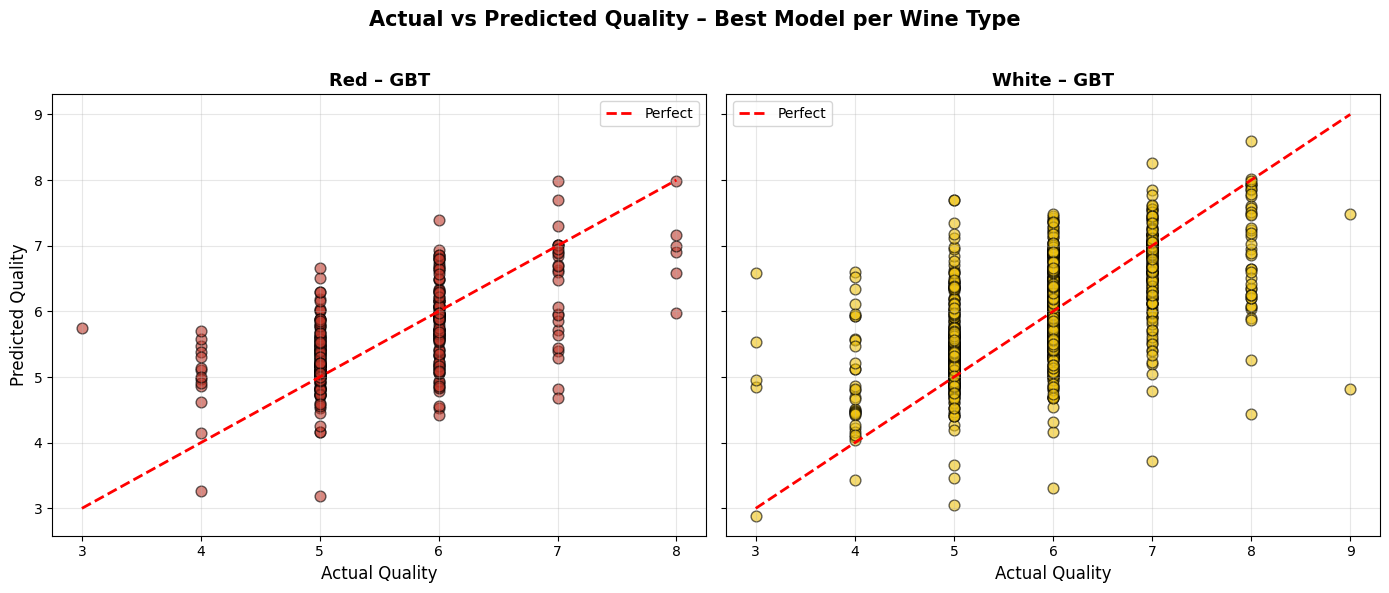


Correlation (Red)   : 0.591
Correlation (White) : 0.608


**Sample Predictions – Red Wine (first 10 test rows):**

Row,actual,prediction
1,8.000000,5.970000
2,8.000000,6.903000
3,8.000000,7.985000
4,8.000000,6.998000
5,8.000000,6.580000
6,8.000000,7.157000
7,7.000000,4.821000
8,7.000000,5.718000
9,7.000000,5.393000
10,7.000000,6.631000


**Sample Predictions – White Wine (first 10 test rows):**

Row,actual,prediction
1,8.000000,7.943000
2,8.000000,6.044000
3,8.000000,7.610000
4,8.000000,6.343000
5,8.000000,5.897000
6,8.000000,6.067000
7,8.000000,7.477000
8,8.000000,7.856000
9,8.000000,6.083000
10,8.000000,6.355000


In [8]:
# =============================================================================
# STEP 5: PREDICTION VS ACTUAL PLOT
# =============================================================================
print("\n" + "="*60)
print("STEP 5: PREDICTION VS ACTUAL PLOT (Best Model – RED & WHITE SEPARATELY)")
print("="*60)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

def pick_best_pred(results_dict, gbt_pred, ls_pred, rf_pred):
    candidates = [
        ("GBT",          results_dict["gbt_rmse"],    gbt_pred),
        ("LASSO",       results_dict["ls_l1_rmse"], ls_pred),
        ("RandomForest", results_dict["rf_rmse"],    rf_pred)
    ]
    best_name, _, best_pred = sorted(candidates, key=lambda x: x[1])[0]
    return best_name, best_pred

# Red
best_red_name, best_red_pred = pick_best_pred(
    results_red, gbt_pred_red, ls_l1_pred_red, rf_pred_red
)
pred_red_pd = (best_red_pred
               .select("label", "prediction")
               .withColumnRenamed("label", "actual")
               .toPandas())

# White
best_white_name, best_white_pred = pick_best_pred(
    results_white, gbt_pred_white, ls_l1_pred_white, rf_pred_white
)
pred_white_pd = (best_white_pred
                 .select("label", "prediction")
                 .withColumnRenamed("label", "actual")
                 .toPandas())

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
for ax, df_pd, wine, name in zip(
    axes, [pred_red_pd, pred_white_pd], ["Red", "White"], [best_red_name, best_white_name]
):
    color = "#C0392B" if wine == "Red" else "#F1C40F"
    ax.scatter(df_pd["actual"], df_pd["prediction"], alpha=0.6, edgecolors="k", s=60, color=color)
    lims = [df_pd["actual"].min(), df_pd["actual"].max()]
    ax.plot(lims, lims, 'r--', lw=2, label="Perfect")
    ax.set_xlabel("Actual Quality", fontsize=12)
    ax.set_title(f"{wine} – {name}", fontsize=13, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Predicted Quality", fontsize=12)
plt.suptitle("Actual vs Predicted Quality – Best Model per Wine Type", fontsize=15, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Correlations
corr_red   = pred_red_pd["actual"].corr(pred_red_pd["prediction"])
corr_white = pred_white_pd["actual"].corr(pred_white_pd["prediction"])
print(f"\nCorrelation (Red)   : {corr_red:.3f}")
print(f"Correlation (White) : {corr_white:.3f}")

# Sample predictions
def show_sample(df_pd, wine):
    display(Markdown(f"**Sample Predictions – {wine} Wine (first 10 test rows):**"))
    sample = df_pd.head(10).round(3)
    sample.insert(0, "Row", range(1, len(sample)+1))
    display(sample.style.hide(axis="index"))

show_sample(pred_red_pd,   "Red")
show_sample(pred_white_pd, "White")

In [9]:
# =============================================================================
# FINAL RESULTS SUMMARY
# =============================================================================
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

def get_best_model(results_dict):
    candidates = [
        ("GBT",          results_dict["gbt_rmse"]),
        ("ls-L1",       results_dict["ls_l1_rmse"]),
        ("RandomForest", results_dict["rf_rmse"])
    ]
    best_name, best_rmse = sorted(candidates, key=lambda x: x[1])[0]
    return best_name, best_rmse

best_red_name,   best_red_rmse   = get_best_model(results_red)
best_white_name, best_white_rmse = get_best_model(results_white)

summary_rows = [
    ["Red",
     f"{results_red['gbt_rmse']:.4f}",   f"{results_red['gbt_r2']:.4f}",
     f"{results_red['ls_l1_rmse']:.4f}",f"{results_red['ls_l1_r2']:.4f}",
     f"{results_red['rf_rmse']:.4f}",   f"{results_red['rf_r2']:.4f}",
     f"**{best_red_name}** (RMSE {best_red_rmse:.4f})"],

    ["White",
     f"{results_white['gbt_rmse']:.4f}",   f"{results_white['gbt_r2']:.4f}",
     f"{results_white['ls_l1_rmse']:.4f}",f"{results_white['ls_l1_r2']:.4f}",
     f"{results_white['rf_rmse']:.4f}",   f"{results_white['rf_r2']:.4f}",
     f"**{best_white_name}** (RMSE {best_white_rmse:.4f})"]
]

summary_df = pd.DataFrame(summary_rows,
    columns=["Wine","GBT RMSE","GBT R²","ls‑L1 RMSE","ls‑L1 R²","RF RMSE","RF R²","BEST MODEL"])

print(summary_df.to_string(index=False))

display(Markdown(f"""
**Best Model Summary**
- **Red Wine**  to **{best_red_name}** (RMSE = {best_red_rmse:.4f})
- **White Wine** to **{best_white_name}** (RMSE = {best_white_rmse:.4f})
"""))


FINAL RESULTS SUMMARY
 Wine GBT RMSE GBT R² ls‑L1 RMSE ls‑L1 R² RF RMSE  RF R²            BEST MODEL
  Red   0.6815 0.2690     0.9835  -0.5226  0.7093 0.2081 **GBT** (RMSE 0.6815)
White   0.7754 0.2817     0.9774  -0.1414  0.8452 0.1466 **GBT** (RMSE 0.7754)



**Best Model Summary**
- **Red Wine**  to **GBT** (RMSE = 0.6815)
- **White Wine** to **GBT** (RMSE = 0.7754)
